In [1]:
from astropy.io import fits #to read in FITS files
from astropy.wcs import WCS #to read coordinates
from reproject import reproject_interp #to align images
import os # os.path to manipulate file paths 
import glob # finding pathnames (to search for certain fits files in folders and subfolders)
import numpy as np # math applied to arrays (important, no need to read pixel for pixel!)
from matplotlib import pyplot as plt #plot library 
from astropy.visualization import ZScaleInterval #create minimum and maximum Z values for plotting 
from astropy.stats import sigma_clip as astropy_sigma_clip


In [2]:
# Returns the header and data of a .fit file.
def get_data(data_im):
    hdu = fits.open(data_im)[0]
    header = hdu.header 
    data = hdu.data

    print(header)

    return header, data

# Change the data with whatever fit you're using.
# Easiest to 'copy relative path' if you're using the GitHub folder.
# Don't forget to change \ to /.
fit_g = "NGC_4449_g_stack_astrometry.fits"
fit_r = "NGC_4449_r_stack_astrometry.fits"
fit_L = 'NGC_4449_L_stack_astrometry.fits'
fit_ha = 'NGC_4449_ha_stack_astrometry.fits'

header_L, dat_L = get_data(fit_L)
header_g, dat_g = get_data(fit_g)
header_r, dat_r = get_data(fit_r)
header_ha, dat_ha = get_data(fit_ha)


SIMPLE  =                    T                                                  BITPIX  =                  -32 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 4096 /fastest changing axis                           NAXIS2  =                 4096 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =  0.00000000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2024-05-23T22:26:22.06' /YYYY-MM-DDThh:mm:ss observation, UT         EXPTIME =   60.000000000000000 /Exposure time in seconds                        EXPOSURE=   60.000000000000000 /Exposure time in seconds                        SET-TEMP=  -10.000000000000000 /CCD temperature setpoint in C                   CCD-TEMP=  -10.000000000000000 /CCD temperature at start of exposure in C       XPIXSZ  =   9.0000000000000000 /Pixel Wi

Below code for aligning images

In [3]:
# Reference coordinates.
wcs_ref = WCS(header_g)

# Aligns image with the reference coordinates.
def reproject_image(image_filename, wcs_ref):
    hdu = fits.open(image_filename)[0]
    array, footprint = reproject_interp(hdu, wcs_ref)
    return array

aligned_g = reproject_image(fit_g, wcs_ref)
aligned_r = reproject_image(fit_r, wcs_ref)
aligned_ha = reproject_image(fit_ha, wcs_ref)
aligned_L = reproject_image(fit_L, wcs_ref)

AttributeError: 'Axes' object has no attribute 'plt'

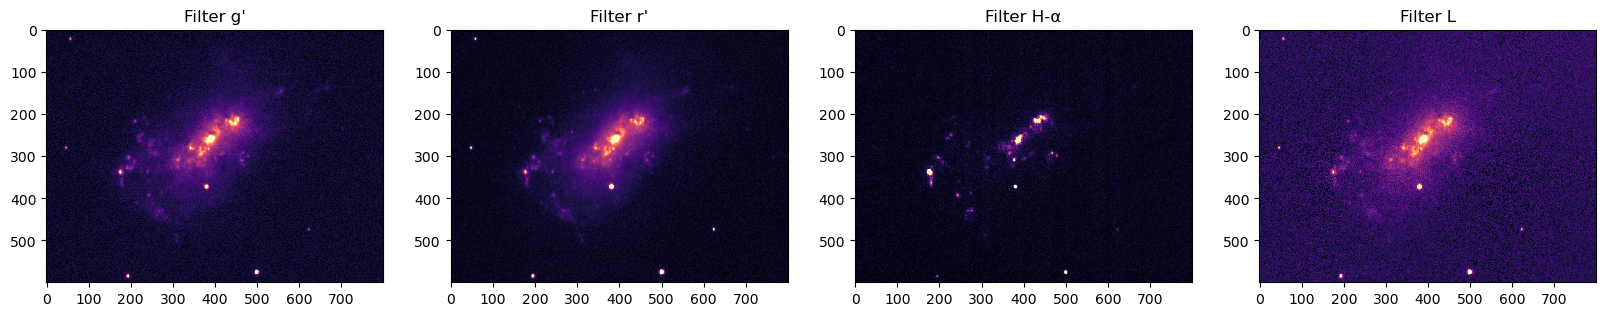

In [6]:
# x, y limits to crop images (1600, 2400, 1800, 2400 to see only NGC 4449)
x_min, x_max, y_min, y_max = 1600, 2400, 1800, 2400

# Crop the images
cropped_g= aligned_g[y_min:y_max, x_min:x_max]
cropped_r = aligned_r[y_min:y_max, x_min:x_max]
cropped_ha = aligned_ha[y_min:y_max, x_min:x_max]
cropped_L = aligned_L[y_min:y_max, x_min:x_max]

# Visualize the cropped images
quantiles_g = np.percentile(cropped_g, (0.1, 99.9))
quantiles_r = np.percentile(cropped_r, (0.1, 99.9))
quantiles_ha = np.percentile(cropped_ha, (0.1, 99.9))
quantiles_L = np.percentile(cropped_L, (0.1, 99.9))
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cropped_g, cmap='magma', vmin = quantiles_g[0], vmax = quantiles_g[1], interpolation = 'nearest')
axs[0].set_title("Filter g'")
axs[1].imshow(cropped_r, cmap='magma', vmin = quantiles_r[0], vmax = quantiles_r[1], interpolation = 'nearest')
axs[1].set_title("Filter r'")
axs[2].imshow(cropped_ha, cmap='magma', vmin = quantiles_ha[0], vmax = quantiles_ha[1], interpolation = 'nearest')
axs[2].set_title("Filter H-α")
axs[3].imshow(cropped_L, cmap='magma', vmin = quantiles_L[0], vmax = quantiles_L[1], interpolation = 'nearest')
axs[3].set_title('Filter L')
plt.show()

Calculate background noise and subtract it from the data

In [ ]:
# Calculate distance from the center of each point
def calc_distance(image, x_center, y_center):
    
    # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)

    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances

x_center = 395
y_center = 260
distances = calc_distance(cropped_g, x_center, y_center)


In [ ]:
# Calculate background noise
def calc_background(image, xmin, xmax, ymin, ymax):
    background_region = image[ymin:ymax, xmin:xmax]
    average = np.mean(background_region)
    return average

xmin, xmax = 0, 150
ymin, ymax = 50, 250

bg_mean_L = calc_background(cropped_L, xmin, xmax, ymin, ymax)
bg_mean_ha = calc_background(cropped_ha, xmin, xmax, ymin, ymax)
bg_mean_r = calc_background(cropped_r, xmin, xmax, ymin, ymax)
bg_mean_g = calc_background(cropped_g, xmin, xmax, ymin, ymax)

no_bg_g = cropped_g - bg_mean_g
no_bg_r = cropped_r - bg_mean_r
no_bg_ha = cropped_ha - bg_mean_ha
no_bg_L = cropped_L - bg_mean_L

0.8241972207645176


In [ ]:
# Function to sigma clip the data
# Sigma sets the amount of standarddeviations in which data is allowed
# Maxiters sets the amount of times clipping is done
def sigma_clip(image, sigma, maxiters):
    clipped_data = astropy_sigma_clip(image, sigma=sigma, maxiters=maxiters, cenfunc='median', stdfunc='std')
    # Fill up masked points with NaN values
    return clipped_data.filled(np.nan)


sigma = 5
maxiters = 5
clipped_ha = sigma_clip(no_bg_ha, sigma, maxiters)
clipped_g = sigma_clip(no_bg_g, sigma, maxiters)
clipped_L = sigma_clip(no_bg_L, sigma, maxiters)
clipped_r = sigma_clip(no_bg_r, sigma, maxiters)
    

In [ ]:
# Function to calculate the flux
def convert_to_magnitude(image, zero_point):
    # Add a min flux to avoid log(0)
    min_flux = 1e-10
    flux = -2.5 * np.log10(np.maximum(image,min_flux)/60) + zero_point
    return flux

# Zero_point is the apparent magnitude of a known star
# Should be different for each filter
zero_point = 25
magnitude_ha = convert_to_magnitude(clipped_ha, zero_point)
magnitude_L = convert_to_magnitude(clipped_L, zero_point)
magnitude_r = convert_to_magnitude(clipped_r, zero_point)
magnitude_g = convert_to_magnitude(clipped_g, zero_point)




In [ ]:
# Calculates the color index
def calc_color_index(filter1, filter2):
    color_index = filter1 - filter2
    return color_index

color_index_g_min_r = calc_color_index(magnitude_g, magnitude_r)

In [ ]:
# Flatten arrays to use it for plot
color_index_flat = color_index_g_min_r.flatten()
g_flat = magnitude_g.flatten()
distances_flat = distances.flatten()

# Remove NaN values from arrays
valid_indices = ~np.isnan(g_flat) & ~np.isnan(color_index_flat)

g_flat = g_flat[valid_indices]
color_index_flat = color_index_flat[valid_indices]
distances_flat = distances_flat[valid_indices]

plt.figure(figsize=(10, 8))
plt.scatter(color_index_flat, g_flat, c=distances_flat, cmap='magma', s=1, alpha=0.5)
plt.xlabel('Color Index (g - r)')
plt.ylabel('Magnitude (g)')
plt.title('Color-Magnitude Diagram')
plt.xlim(-15, 15)
plt.ylim(25, 45)
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.colorbar()
plt.grid(True)
plt.show()

NameError: name 'color_index_g_min_r' is not defined